In [82]:
import sys, os
import os
import torch
import torchvision.transforms as transforms

home_dir = os.path.abspath(os.getcwd()+"/../")
print(home_dir)
sys.path.append(os.path.join(home_dir, 'lib'))
sys.path.append(home_dir)

from lib.models.backbones.vit import ViT
from lib.models.heads import UncertaintyDeconvDepthWiseChannelHead
from lib.models.heads import TopdownHeatmapSimpleHead
from lib.dataset.coco import COCODataset
from lib.core.config import config
from lib.core.config import update_config
# from lib.models.extra.vit_large_uncertainty_config import extra
from lib.models.extra.vit_huge_uncertainty_config import extra

from lib.models.uncertainty_pose import UncertaintyPose
from lib.models.vit_pose import ViTPose

from lib.utils.vis import display_heatamp, display_keypoints, display_keypoints_with_uncertainty, coco_info, skeleton_connection_info
import cv2
import numpy as np


/home/yongju/Github/HPE_HOI/HPE


In [83]:
torch.cuda.is_available()

# update_config(home_dir + '/experiments/coco/vit/vit_large_uncertainty.yaml')
update_config(home_dir + '/experiments/coco/vit/vit_huge_uncertainty.yaml')


In [84]:
# update_config(home_dir + '/experiments/coco_tiny/hrformer/256x192_d32x0_adamW_lr5e-4_uncertainty.yaml')
config.DATASET.TARGET_KEYPOINT = True
config.DATASET.TARGET_HEATMAP = True

config.TEST.USE_GT_BBOX = True

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
# torch.manual_seed(10)
torch.manual_seed(0)

In [85]:
test_dataset = COCODataset(
    cfg=config, 
    root='/data/coco/', 
    image_set='val2017', 
    is_train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True,
)



loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


In [86]:
from copy import deepcopy
## Backbone - ViT
backbone = ViT(
    img_size=extra["backbone"]["img_size"],
    patch_size=extra["backbone"]["patch_size"],
    embed_dim=extra["backbone"]["embed_dim"],
    in_channels=3,
    num_heads=extra["backbone"]["num_heads"],
    depth=extra["backbone"]["depth"],
    qkv_bias=True,
    drop_path_rate = extra["backbone"]["drop_path_rate"]
)

## HEAD - Heatmap Simple Head
deconv_head = TopdownHeatmapSimpleHead(
    in_channels=extra["keypoint_head"]["in_channels"],
    num_deconv_layers=extra["keypoint_head"]["num_deconv_layers"],
    num_deconv_filters=extra["keypoint_head"]["num_deconv_filters"],
    num_deconv_kernels=extra["keypoint_head"]["num_deconv_kernels"],
    extra=dict(final_conv_kernel=1),
    out_channels=17,
)

## Uncertainty head
uncertainty_head = UncertaintyDeconvDepthWiseChannelHead(
    extra["uncertainty_channel_head"], norm_cfg=dict(type="BN")
)
model = UncertaintyPose(backbone, deconv_head, uncertainty_head, config)
model_official = ViTPose(deepcopy(backbone), deepcopy(deconv_head))

model.eval()
model_official.eval()
# model = model.cuda()

ViTPose(
  (backbone): ViT(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps

In [87]:
from lib.core.inference import post_dark_udp
from lib.core.inference import get_final_preds

def get_max_preds(heatmaps):
    """
    get predictions from score maps+
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    """
    assert isinstance(heatmaps, np.ndarray), "heatmaps should be numpy.ndarray"
    assert heatmaps.ndim == 4, "batch_images should be 4-ndim"
    N, K, _, W = heatmaps.shape
    heatmaps_reshaped = heatmaps.reshape((N, K, -1))
    idx = np.argmax(heatmaps_reshaped, 2).reshape((N, K, 1))
    maxvals = np.amax(heatmaps_reshaped, 2).reshape((N, K, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)
    preds[:, :, 0] = preds[:, :, 0] % W
    preds[:, :, 1] = preds[:, :, 1] // W

    preds = np.where(np.tile(maxvals, (1, 1, 2)) > 0.0, preds, -1)
    return preds, maxvals


In [88]:
checkpoint_path = home_dir + "/checkpoints/vit_huge_77_1.pth.tar"
checkpoint_official = home_dir + "/checkpoints/vitpose-h.pth"
model = model.custom_init_weights(model, checkpoint_path)

model_official.init_weights(checkpoint_official)
print()

checkpoint path :  /home/yongju/Github/HPE_HOI/HPE/checkpoints/vit_huge_77_1.pth.tar
Succesfully init weights..
Please verify once again!!
Not applied "seed"
Not applied "epoch"
Not applied "mmcv_version"
Succesfully init weights..
The parameters of the original pretrained model and your model are identical!



In [89]:
from lib.core.inference import get_final_preds
from lib.core.inference import post_dark_udp
import matplotlib.pyplot as plt

len(test_dataset)

6352

['/data/coco/images/val2017/000000401250.jpg', '/data/coco/images/val2017/000000176857.jpg', '/data/coco/images/val2017/000000411938.jpg']


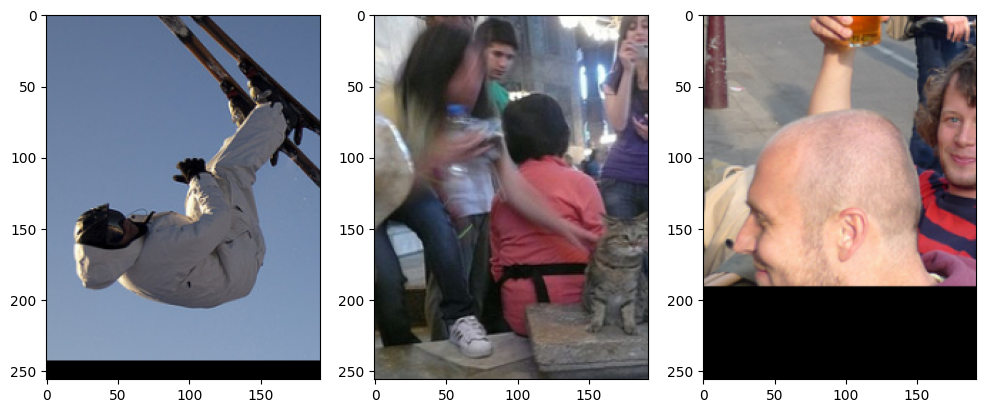

In [101]:
img, target_keypoints, target_keypoints_weight, heatmap, heatamp_weight, meta = next(iter(test_loader))


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

for i in range(3):
    ax[i].imshow(img.permute(0,2,3,1)[i])    
print(meta['image'])

plt.show()



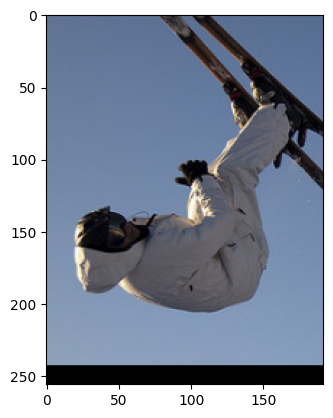

In [102]:
plt.imshow(img.permute(0,2,3,1)[0])


In [103]:
np.set_printoptions()  # 소수점 이하 자릿수 0, 지수 표현 비활성화

with torch.no_grad():
    # pose_output = model.forward(img.cuda())
    pose_output = model.forward(img)
    pose_output_official = model_official.forward(img)

    g_t_preds, _1 = model.get_max_preds(heatmap.detach().cpu().numpy())

keys_huge, uncertainty_huge, _, hm_huge = pose_output

preds_huge, value_huge = get_max_preds(hm_huge.detach().cpu().numpy())

preds_huge_official, _ = get_max_preds(pose_output_official.detach().cpu().numpy())
# preds_huge = post_dark_udp(preds_huge, hm_huge.detach().cpu().numpy(), 11)

In [104]:
soft_plus = torch.nn.Softplus()

uncertainty_map_huge = soft_plus(uncertainty_huge)

if config.LOSS.USE_INDEXING:
    # kp_ = np.round(target.detach().cpu().numpy() / 4)
    # kp_ = np.round(keys_huge.detach().cpu().numpy())
    kp_ = np.round(preds_huge)

    x = np.clip(kp_[:, :, 0], 0, config.MODEL.HEATMAP_SIZE[0] - 1)
    y = np.clip(kp_[:, :, 1], 0, config.MODEL.HEATMAP_SIZE[1] - 1)

    # Uncertainty Map has 1 channel
    sigma_x = torch.diagonal(uncertainty_map_huge[:, 0, y, x], dim1=0, dim2=1).permute(
        1, 0
    )

    uncertainty_huge = torch.cat([sigma_x.unsqueeze(-1), sigma_x.unsqueeze(-1)], dim=-1)

# get uncertainty 
sigma_x = sigma_x.detach().cpu().numpy()

# Plot Joint Keypoint Skeleton ! 

Function is defined just below cell

In [105]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

def draw_skeleton(img, predict_keypoints, uncertainty, idx=0):
    plt.imshow(img.permute(0,2,3,1)[idx])
    plt.axis('off')
    ax = plt.gca()
    ax.set_autoscale_on(False)

    uncertainty_thr = 1.5
    # if len(predict_keypoints.shape) == 3:
    pred_kp = predict_keypoints[idx] * 4 
    # else:
    #     pred_kp = predict_keypoints * 4 
    uncertainty = uncertainty[idx]
    x = pred_kp[:,0]
    y = pred_kp[:,1]
    for i, sk in enumerate(skeleton_connection_info['SKELETON']):

        plt.plot(x[sk], y[sk], linewidth=2, color=skeleton_connection_info['COLOR'][i])

    plt.plot(x[uncertainty>uncertainty_thr], y[uncertainty>uncertainty_thr],'o',markersize=8, markerfacecolor=[1,0,0], markeredgecolor='k',markeredgewidth=2)
    plt.plot(x[uncertainty<uncertainty_thr], y[uncertainty<uncertainty_thr],'o',markersize=4, markerfacecolor=[1,1,1], markeredgecolor=[0,0,0], markeredgewidth=2)



# Visualization

keypoint 색상은 lib/utils/vis.py 내부에 있는 skeleton_connection_info 부분 참고하셔서 변경하실 수 있으십니다!! 



> 붉은색 keypoint 동그라미는 Uncertain한 Keypoint이며, 흰색으로 plot된 keypoint는 certain한 부분입니다. 

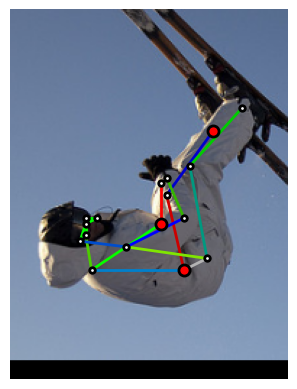

In [106]:
draw_skeleton(img, preds_huge,sigma_x,0)
plt.show()

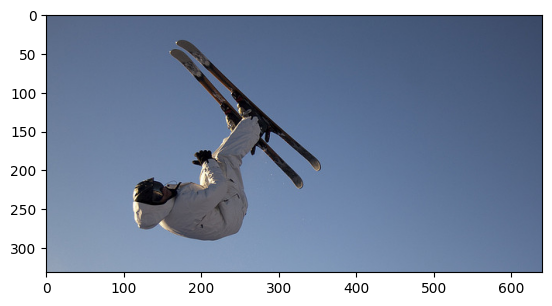

In [107]:
img = cv2.imread('/data/coco/images/val2017/000000401250.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


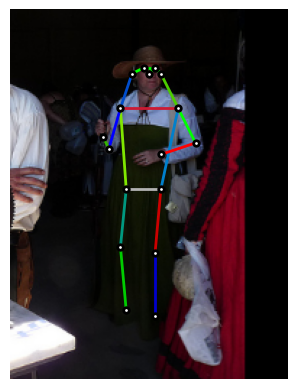

In [18]:
draw_skeleton(img, preds_huge,sigma_x,1)
plt.show()

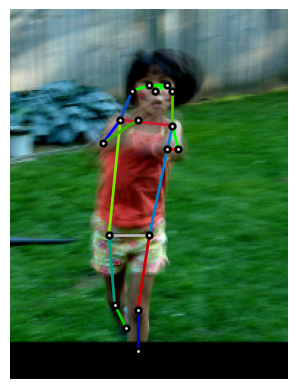

In [51]:
draw_skeleton(img, preds_huge,sigma_x,2)
plt.show()